## Data Loading and Augmentation Using PyTorch

#### Building efficient data loaders with PyTorch

- Load the data using PyTorch data loader
- Augment the image datatset using PyTorch
- Visualize the augemented data

In this notebook, we will implement the **PyTorch** utilities for data loading/augmenting. We will discover PyTorch's modular approach, which seperates data *representation* from *data iteration*
- Custom `Dataset` Class: We will build our own dataset class from scratch by inheriting from `torch.utils.data.Dataset`. This will give us full control and a deep understanding of the data pipeline. 
- In-built `ImageFolder` utility: We will use the convenient `torchvision.datasets.ImageFolder` class, which automatically handles data from a standard directory structure.
- The `DataLoader`: We will wrap both of our datasets in a `DataLoader`, PyTorch's engine for efficient batching, shuffling, and parallelized data loading.

Finally, we will compare these methods to understand why this modulat design is so powerful.

#### Step 1: Install required libraries

In [1]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork
%pip install pandas==2.2.3

CPU times: total: 15.6 ms
Wall time: 6.27 s


In [2]:
%pip uninstall torch -y
%pip uninstall torchvision==0.22 -y

Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Note: you may need to restart the kernel to use updated packages.
Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%time
%pip install torch

  Using cached torch-2.8.0-cp39-cp39-win_amd64.whl.metadata (30 kB)
Using cached torch-2.8.0-cp39-cp39-win_amd64.whl (241.2 MB)
Note: you may need to restart the kernel to use updated packages.
CPU times: total: 93.8 ms
Wall time: 34.9 s


In [4]:
%%time
%pip install torchvision

  Using cached torchvision-0.23.0-cp39-cp39-win_amd64.whl.metadata (6.1 kB)
Using cached torchvision-0.23.0-cp39-cp39-win_amd64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.
CPU times: total: 46.9 ms
Wall time: 3.63 s


In [5]:
# define a function to check for successful installation of the libraries
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("❌ Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("✅ Library installation was successful, let's proceed ahead")    

lib_installation_check(captured_data = captured_output, n_lines_print = 5)

✅ Library installation was successful, let's proceed ahead


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skillsnetwork
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

#### Step 2: Define the directories

In [7]:
extract_dir = "."
# Define directories
base_dir = os.path.join(extract_dir, 'images_dataSAT')
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

#### Step 3: Custom PyTorch `Dataset`

In PyTorch, 
- A `Dataset` object is an iterable (gives one sample at a time).
- A `DataLoader` is an iterator that returns batches (adds a batch dimension: `[B, C, H, W]`).
- To create a custom dataset, we will create a class that inherits from `torch.utils.data.Dataset` and implements three essential methods: 
    - `__init__(self)`: This method is ran once when the dataset is instantiated. It is when you perform initial setup, such as loading file paths and labels.
    - `__len__(self)`: This returns the total number of samples in the dataset.
    - `__getitem__(self, idx)`: This method is responsible for loading and returning a *single* sample from the dataset at the given index `idx`. This is the core of sequential loading; it fetches one data point from storage "just-in-time".
    

In [ ]:
class CustomBinaryClassDataset(Dataset):
    def __init__(self, non_agri_dir, agri_dir, transform=None):
        """
        Args:
            non_agri_dir (string): Directory with all the non-agricultural images.
            agri_dir (string): Directory with all the agricultural images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load non_agri paths and assign label 0
        for file_name in os.listdir(non_agri_dir):
            self.image_paths.append(os.path.join(non_agri_dir, file_name))
            self.labels.append(0)

        # Load agri paths and assign label 1
        for file_name in os.listdir(agri_dir):
            self.image_paths.append(os.path.join(agri_dir, file_name))
            self.labels.append(1)

        # Shuffle
        temp = list(zip(self.image_paths, self.labels))
        np.random.shuffle(temp)
        self.image_paths, self.labels = zip(*temp)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB") # Ensure image is in RGB format

        label = self.labels[idx]

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)

        return image,label
    



#### Step 4: Define transformations 

- `torchvision.transforms` provides a suite of common image transformations. These are used for preprocessing (such as `resizing` and `converting to a tensor`) and data augmentation (such as `random flips` and `rotations`)
- `transforms.Compose` chains these operations together into a single, callable pipeline. Data augmentation is a crucial regularizatrion technique that helps prevent overfitting by showing the model slightly different versions of the same image at each epoch.
- Transforms like `RandomFlip` and `Rotation` work on PIL images and must be applies before `ToTensor()`, which converts images to tensors. 
- `Normalize()` scales tensor values (eg,. form `[0, 1]` to `[-1,1]`) using `(x - mean) / std` or can be based on model we are fine tuning.

In [9]:
test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(20),
                                    transforms.ToTensor(), # Converts PIL Image to a tensor and scales values to [0, 1]
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]) # Normalize to [-1, 1]
                                    ])

Now that we know how a data augmentation pipeline works in PyTorch, let us create a transformation pipeline `custom_transform` for the given specifications.

#### Step 5: Create a transformation pipeline `custom_transform`

In [10]:
custom_transform = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.2),
                                       transforms.RandomRotation(45),           
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Nomarlize to [-1, 1]                       
                                       ])

##### In-built `ImageFolder` utility

For datasets that follow a standard `root/class_name/xxx.ext` directory structure, PyTorch provides `torchvision.datasets.ImageFolder`. This is a specialized `Dataset` class that does all the work of finding image paths and inferring class labels for you. It's the most convenient way to load image datasets organized in folders, where each subfolder represents a different class.

**ImageFolder** acts as a quick bridge between raw image files and PyTorch models. We can point the `root` argument at the top-level dataset folder, and the class automatically walks through every subfolder, using each subfolder’s name as a label. We can attach a `transform pipeline` with common choices including `transforms.Resize`, `transforms.CenterCrop`, `transforms.ToTensor`, and `transforms.Normalize` to pre-process every image on the fly. Calling `len(dataset)` reveals total images, while indexing `dataset[i]` returns an `(image, label)` pair. We can then combine it with `DataLoader` to batch, shuffle, and parallel-load data effortlessly.

**ImageFolder** works on the `dataset folder` structured as represented below:

    dataset/
    ├── class1/
    │   ├── image1.jpg
    │   └── image2.jpg
    └── class2/
        ├── image3.jpg
        └── image4.jpg

From this dataset, we can create a `dataset object` like this: 

```
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(
    root='path/to/dataset',
    transform=transform

```

Then, we can use this `dataset object` to create a `dataloader` like this:
```
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    # Your training code here
    .
    .
    ...

```

This `dataloader` can then be used for creating batches of images for training / testing of the model.

`ImageFolder` automatically assigns numerical labels to classes based on folder names alphabetically. Access class names via `dataset.classes` and class-to-index maping via `dataset.class_to_idx`

#### Step 6: Get the datatset **imagefolder_dataset** using `datsets.Imagefolder` mathod and applying **custom_transform**

In [11]:
imagefolder_dataset = datasets.ImageFolder(
    root=base_dir,
    transform=custom_transform
)

#### Step 7: Print the name and the class index from the **imagefolder_dataset**

In [12]:
print(f"Classes found by ImageFolder: {imagefolder_dataset.classes}")
print(f"Classes found by index mapping: {imagefolder_dataset.class_to_idx}")


Classes found by ImageFolder: ['class_0_non_agri', 'class_1_agri']
Classes found by index mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}


#### Step 7: Bringing it all together - The `DataLoader`

The `DataLoader` is an iterator that returns batches, based on the `batch_size`. It wraps a `Dataset` object and provides an iterable to access the data. Its key responsbilities are: 
- **Batching**: This involves grouping individual samples into mini-batches.
- **Shuffling**: This involves randomly shuffling the data every epoch to prevent the model from learning the order of samples. The data loading process is parallelized, preventing the CPU from becoming a bottleneck for the GPU.

We can use the `DataLoader` with **both** our `CustomBinaryClassDatset` and the `ImageFolder` dataset.

Linear and convolution layers in a neural network can work **with or without** the batch dimension
- eg., with shapes `[C, H. W]` or `[B, C, H, N]`, where:
    - B: batch_size
    - C: number of channels
    - H: Image height
    - W: Image width

In [22]:
BATCH_SIZE = 8

# Using our custom dataset
custom_dataset = CustomBinaryClassDataset(dir_non_agri, dir_agri, transform=custom_transform)
custom_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)#2)

# Using the ImageFolder Dataset
imagefolder_loader = DataLoader(imagefolder_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("DataLoaders created")

DataLoaders created


#### Step 8: Visualize a batch

Let us inspect a batch from our `DataLoader`. We can use `iter()` and `next()` to pull a single batch. This is exactly what a training loop does under the hood. Visuailizing the images and their labels confirms that our entire pipeline (from path loading and transforming to batching) is working correctly.

In [23]:
# Get one batch from the Custom loader
images_custom, labels_custom = next(iter(custom_loader))

print(f"Images batch shape (Custom loader): {images_custom.shape}")
print(f"Labels batch shape (Custom loader): {labels_custom.shape}")


Images batch shape (Custom loader): torch.Size([8, 3, 64, 64])
Labels batch shape (Custom loader): torch.Size([8])


#### Step 9: Get a batch of imahes and labels from the `imagefolder_loader` and print their shape

In [14]:
images_inbuilt, labels_inbuilt = next(iter(imagefolder_loader))

print(f"Images batch shape (PyTorch in-built loader): {images_inbuilt.shape}")
print(f"Labels batch shape (PyTorch in-built loader): {labels_inbuilt.shape}")

Images batch shape (PyTorch in-built loader): torch.Size([8, 3, 64, 64])
Labels batch shape (PyTorch in-built loader): torch.Size([8])


In [15]:
def imshow(img):
    # Helper function to un-normalize and display an image
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0))) # Convert from C, H, W to H, W, C

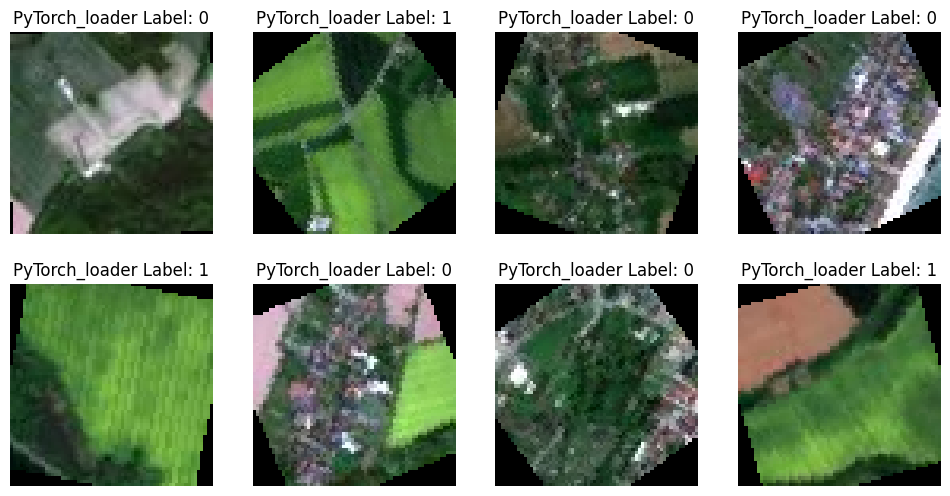

In [16]:
plt.figure(figsize=(12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_inbuilt[i])
    plt.title(f"PyTorch_loader Label: {labels_inbuilt[i].item()}")
    plt.axis("off")

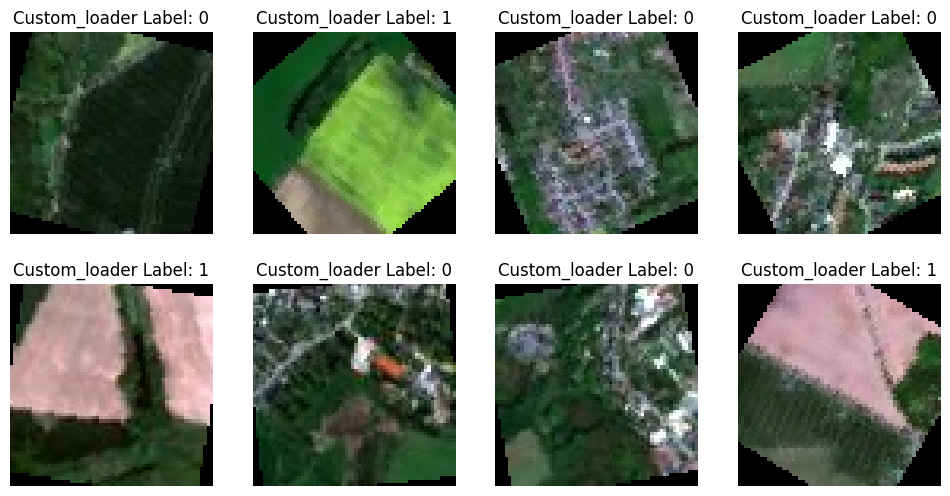

In [24]:
plt.figure(figsize=(12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_custom[i])
    plt.title(f"Custom_loader Label: {labels_inbuilt[i].item()}")
    plt.axis("off")

#### Comparison and analysis

In PyTorch, both methods lead to a `DataLoader`. The key difference lies in how the underlying `Datset` is created.

| Feature                  | Custom `Dataset`                                       | In-built `ImageFolder`     |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. It requires writing a custom class with three specific methods. | High. It requires only a single, intuitive class instantiation. |
| **Code complexity**      | High. You manually manage file paths, labels, and the loading logic inside `__getitem__`. | Low. The class handles all path and label discovery automatically.          |
| **Flexibility**          | Very high. It is essential for non-standard directory structures, loading labels from a CSV/JSON, or complex loading logic (for example, from a database). | Moderate. It strictly requires the `root/class/image.ext` directory structure. |
| **Performance**          | Potentially high. Performance depends on the efficiency of your `__getitem__` method. When wrapped in a `DataLoader` with `num_workers`, it can be highly performant. | High. `ImageFolder` is optimized and, when wrapped in a `DataLoader`, provides excellent performance out-of-the-box. |
| **Recommended for**      | It is recommended for complex, non-standard datasets or when you need fine-grained control over every aspect of data loading. | It is recommended for almost all standard image classification tasks.        |
